In [1]:
%reload_ext autoreload
from env import SingleStateSpace 
from generate_trajectory import generate_trajectory
from policy import Boltzmann 
from learn import compute_q_with_values
from RewardFunctions import SingleStateReward
import numpy as np 
from learn import policy_iteration
from utils import normalise_pi
from policy_walk import policy_walk 
import matplotlib.pyplot as plt 

In [6]:
#Set up the environment
trajectory_length = 20 
env = SingleStateSpace(n_actions = 10, discount_rate = 0.1, R_max = 5)

#generate observation times 
observation_times = np.cumsum(np.random.uniform(0, 2, size=trajectory_length))
print("Generated observation times:") 
print(observation_times)

#Create a matrix for the true rewards 
s_grid, a_grid, t_grid = np.meshgrid(env.states, env.actions, observation_times, indexing='ij')
R = np.vectorize(env.reward)(s_grid,a_grid,t_grid)

#Find the optimal policy, values and q_values for the true reward to generate the trajectory. 
(optimal_pi, optimal_values, optimal_q_values) = policy_iteration(env,trajectory_length,R)
b = Boltzmann(optimal_q_values, env.actions, alpha = 100)

#multiple trajectories are combined - just means that the agent does multiple things at each time slot to allow for more data to be gathered
observations = generate_trajectory(env,b,observation_times, n_trajectories=5)

#Run profiling on policy walk 
# import cProfile
# import re 
# cProfile.run('re.compile(learned_rewards = policy_walk(env,observations,n_observations = trajectory_length,n_iters=10000)[5000:10000])')

#Sample from policy walk - I discard the first half of each policy walk iteration.
learned_rewards = policy_walk(env,observations,n_observations = trajectory_length,n_iters=50000)[25000:]
policy_walk_iters =2
for _ in range(policy_walk_iters-1): 
    learned_rewards = np.concatenate((learned_rewards, policy_walk(env,observations,n_observations = trajectory_length,n_iters=50000)[25000:]))

Generated observation times:
[ 1.69849381  3.02189258  3.83330226  4.53304532  4.55041351  6.1878874
  7.7642873   8.77608535 10.21273115 12.13744168 13.32183961 14.60249329
 14.75486811 15.60835113 17.47664696 18.35034231 18.7473736  20.73398399
 20.97691469 22.83879536]


Analysis of Acceptance Probabilities:

In [4]:
#Scatter plot of thinned acceptance probabilities - change policy_walk to return acceptance probabilities to use
print(np.average(acceptance_probs[37500:]))
plt.scatter(range(len(acceptance_probs[14::15])), acceptance_probs[14::15])
plt.show()

# Moving average of acceptance probabilities
# import math
# window_size = 500
# n_windows = math.floor(len(acceptance_probs)) 
# averages = [] 
# for i in range(n_windows): 
#     averages.append(np.average(acceptance_probs[window_size*i:window_size*(i+1)]))

# plt.plot(averages) 
# plt.show()


NameError: name 'acceptance_probs' is not defined

Analysis of Average Learned Reward Matrix

[ 1.69849381  3.02189258  3.83330226  4.53304532  4.55041351  6.1878874
  7.7642873   8.77608535 10.21273115 12.13744168 13.32183961 14.60249329
 14.75486811 15.60835113 17.47664696 18.35034231 18.7473736  20.73398399
 20.97691469 22.83879536]


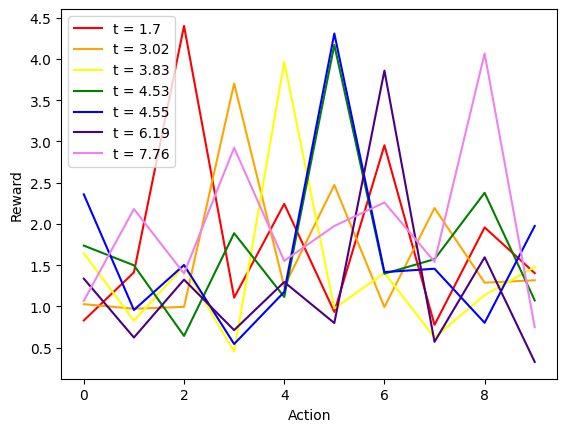

In [7]:
#Shows hte overall learned rewards - switch to the bigger colors array to view all 
# colors = ["#e71d43","#ff0000","#ff3700","#ff6e00","#ffa500","#ffc300","#ffe100","#ffff00","#aad500","#55aa00","#008000","#005555","#002baa","#0000ff","#1900d5","#3200ac","#4b0082","#812ba6","#b857ca","#d03a87"]
avg_reward = np.average(np.asarray(learned_rewards),axis = 0)
print(observation_times)
colors = ["red", "orange","yellow","green","blue","indigo","violet"]
for t in range(7):
    label = "t = " + format(round(observation_times[t],2))
    plt.plot(avg_reward[0,:,t], color=colors[t], label = label)
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.show()

Chain Analysis

[[0, 1, 0], [0, 2, 1], [0, 2, 2], [0, 4, 3], [0, 5, 4], [0, 5, 5], [0, 6, 6], [0, 8, 7], [0, 9, 8], [0, 9, 9], [0, 9, 10], [0, 7, 11], [0, 6, 12], [0, 6, 13], [0, 4, 14], [0, 2, 15], [0, 0, 16], [0, 1, 17], [0, 1, 18], [0, 2, 19]]


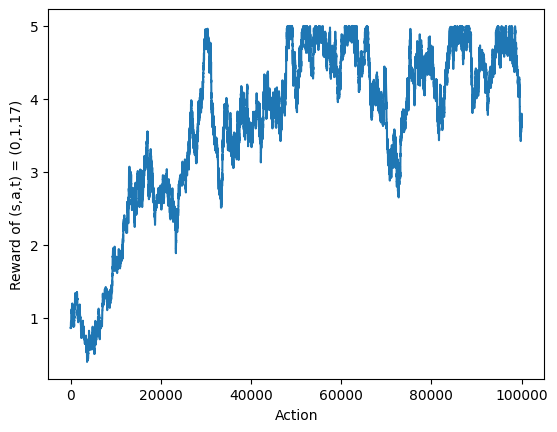

In [24]:
#Used to analyse individual chains: 
print(observations)

#Plot a single reward
s,a,t = 0,1,17
plt.plot(learned_rewards[:,s,a,t])
ylabel = "Reward of (s,a,t) = (" + format(s) + "," + format(a) + "," + format(t) + ")"
plt.ylabel(ylabel)
plt.xlabel("Action")
plt.show()

[[0, 1, 0], [0, 2, 1], [0, 2, 2], [0, 4, 3], [0, 5, 4], [0, 5, 5], [0, 6, 6], [0, 8, 7], [0, 9, 8], [0, 9, 9], [0, 9, 10], [0, 7, 11], [0, 6, 12], [0, 6, 13], [0, 4, 14], [0, 2, 15], [0, 0, 16], [0, 1, 17], [0, 1, 18], [0, 2, 19]]


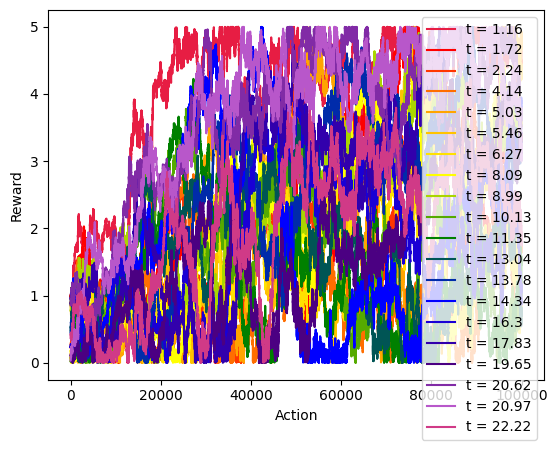

<Figure size 1600x1600 with 0 Axes>

In [31]:
#Plot rewards over time for a given state/action pair - shows observed (s,a,t) pairs in colour 
print(observations)
s,a, = 0,1
# s,t = 0,5
colors = ["#e71d43","#ff0000","#ff3700","#ff6e00","#ffa500","#ffc300","#ffe100","#ffff00","#aad500","#55aa00","#008000","#005555","#002baa","#0000ff","#1900d5","#3200ac","#4b0082","#812ba6","#b857ca","#d03a87"]
for t in range(20):
    label = "t = " + format(round(observation_times[t],2))
    if [s,a,t] in observations: 
        plt.plot(learned_rewards[:,s,a,t], color=colors[t], label = label)
    else:
        plt.plot(learned_rewards[:,s,a,t], color="grey", label = label)        
    
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.figure(figsize=(10,10), dpi=160)
plt.show()